The code in this notebook has been adapted from the work of Zhongy et al. and Greydanus et al. 

Their code is available in the following repositories :[
Symplectic-ODENet](https://github.com/Physics-aware-AI/Symplectic-ODENet) and [hamiltonian-nn](https://github.com/greydanus/hamiltonian-nn)

# Imports & Setting up directories

In [1]:
try:
    import google.colab

    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    PATH = "./"  # './drive/MyDrive/1_SP_Ham_func/'
    from google.colab import drive

    drive.mount("/content/drive")

    %cd /content/drive/MyDrive/1_SP_Ham_func/simple_pendulum/

    %pip install torchdiffeq

    from src.dynamics import *
    from src.data import *
    from src.models_main import *
    from src.models_sub import *
    from src.plots import *
    from src.train import *
    from src.train_helpers import *
else:
    import sys

    sys.path.insert(0, "..")
    import os

    PATH = "./"


from src.dynamics import *
from src.data import *
from src.models_main import *
from src.models_sub import *
from src.plots import *
from src.train import *
from src.utils import *
from src.train_helpers import *

In [2]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import pandas as pd
import numpy as np
import random
from torch.utils.data import Dataset, DataLoader, random_split
import torch

from torch.optim.lr_scheduler import LinearLR

from torchdiffeq import odeint_adjoint as odeint_adjoint

# func must be a nn.Module when using the adjoint method
from torchdiffeq import odeint as odeint

import time as time
import json

In [3]:
# auto reload the source files whenever they are changed
%load_ext autoreload
%autoreload 2

# Training

## Simple_HNN

In [4]:
set_all_seeds(manualSeed=123, new_results=False)

device = set_device()

model_training = Training(
    PATH,
    device,
    w=[1.0, 1.0],
    resnet_config=False,
    horizon=False,
    horizon_type="auto",
    horizon_list=[20, 25, 30, 35, 40],
    switch_steps=[100, 100, 100, 100, 100],
    epoch_num=None,
    loss_type="L2weighted",
    test_every=5,
    print_every=1,
    lr=1e-3,
    weight_decay=1e-4,
    model_name="Simple_HNN_",
    time_steps=200,
    num_trajectories=125,
    batch_size=100,
    proportion=0.8,
    utype=None,
    gtype=None,
    shuffle=False,
    coord_type="hamiltonian",
    save_suffix="",
)

Random Seed:  123
Available device: cpu
Number of training epochs:  500
Paths created
Model initiatialized 
Number of parameters: 7562


In [5]:
model_training._init_data_loaders()
stats = model_training.train()

Generating dataset
Dataset created
horizon length : 20
[  0/500]	 train loss: 7.101315e+00, t_train: 0.39, test loss: 6.728592e+00, t_test: 0.14
[  1/500]	 train loss: 6.924104e+00, t_train: 0.31
[  2/500]	 train loss: 6.747549e+00, t_train: 0.26
[  3/500]	 train loss: 6.569479e+00, t_train: 0.22
[  4/500]	 train loss: 6.387973e+00, t_train: 0.31
[  5/500]	 train loss: 6.201675e+00, t_train: 0.24, test loss: 5.825189e+00, t_test: 0.11
[  6/500]	 train loss: 6.010244e+00, t_train: 0.33
[  7/500]	 train loss: 5.814663e+00, t_train: 0.31
[  8/500]	 train loss: 5.616963e+00, t_train: 0.22
[  9/500]	 train loss: 5.419622e+00, t_train: 0.43
[ 10/500]	 train loss: 5.224831e+00, t_train: 0.47, test loss: 4.997014e+00, t_test: 0.06
[ 11/500]	 train loss: 5.033821e+00, t_train: 0.27
[ 12/500]	 train loss: 4.846577e+00, t_train: 0.25
[ 13/500]	 train loss: 4.661935e+00, t_train: 0.25
[ 14/500]	 train loss: 4.477954e+00, t_train: 0.21
[ 15/500]	 train loss: 4.292538e+00, t_train: 0.21, test loss: 

In [6]:
# save training class that contains dataset and model
pickle_save(model_training, model_training.model_path + "model.pkl")

In [7]:
# load the model
model_training = pickle_load(model_training.model_path + "model.pkl")

### plots

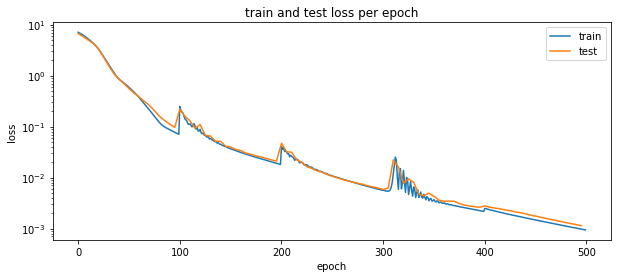

In [8]:
loss_train = model_training.logs["train_loss"]
loss_test = model_training.logs["test_loss"]
epochs = np.arange(len(loss_train))
train_test_loss_plot(
    loss_train,
    loss_test,
    epochs,
    model_training.test_epochs,
    file_path=model_training.plot_path + "simple_pend_losses.png",
    horizons=None,
    horizon_steps=[200, 400, 550, 700, 850],
    title="train and test loss per epoch",
)

In [9]:
train_horizon = model_training.horizon_list[-1]
print(train_horizon)

40


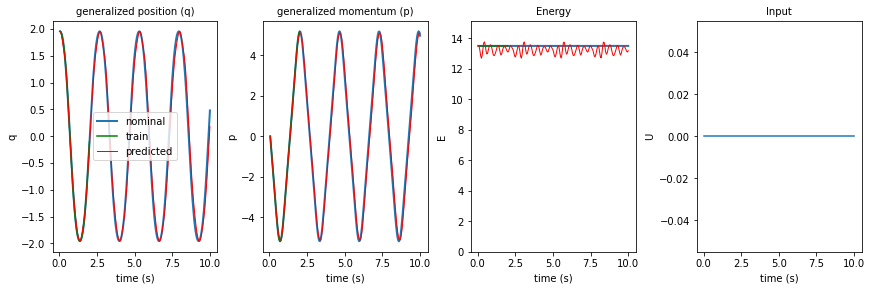

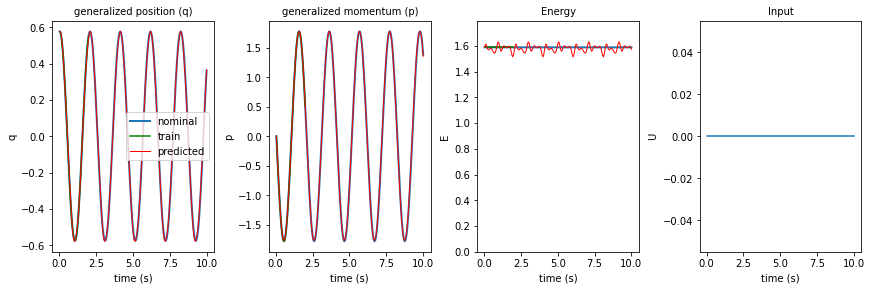

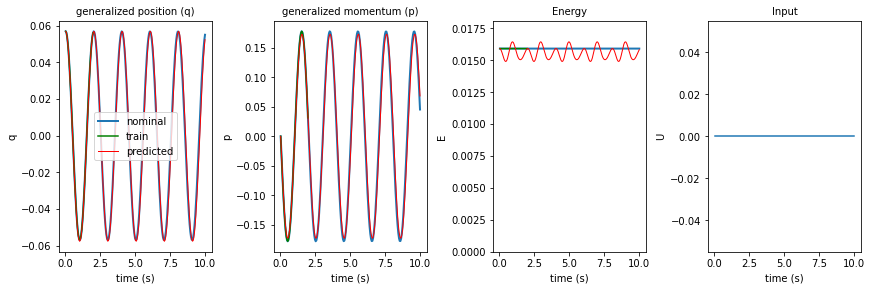

In [10]:
title = ""
for n in [5, 10, 75]:
    plot_results(
        model_training,
        n,
        train_horizon,
        file_path=model_training.plot_path + "simple_pend_train" + str(n) + ".png",
        show_pred=True,
        title=title,
        coord_type="hamiltonian",
    )

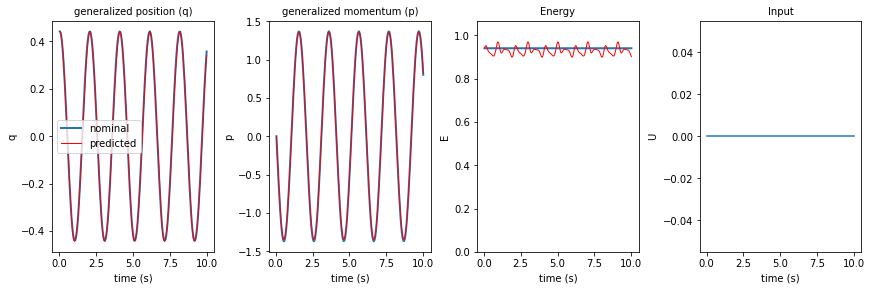

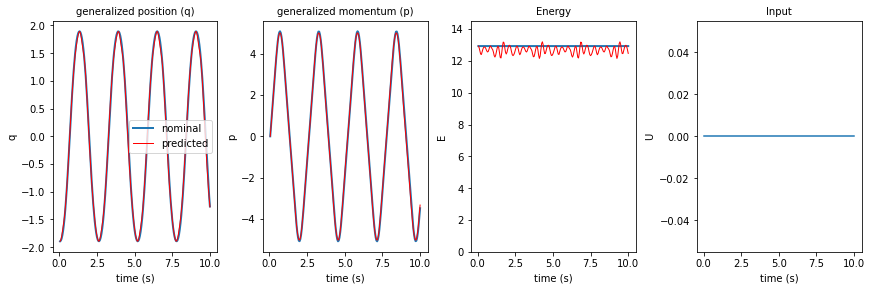

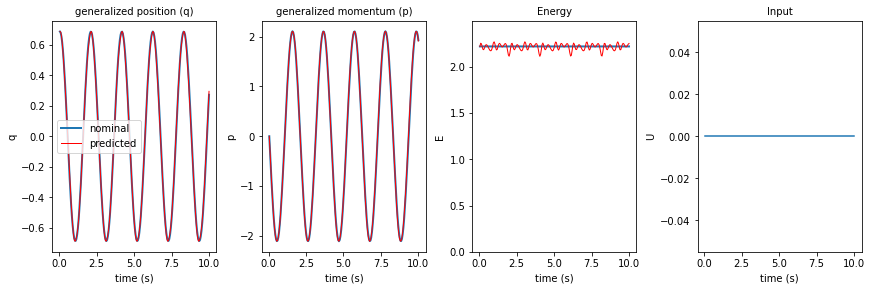

In [11]:
title = ""
for n in [5, 10, 15]:
    plot_results(
        model_training,
        n,
        train_horizon,
        train=False,
        file_path=model_training.plot_path + "simple_pend_test" + str(n) + ".png",
        only_pred=True,
        title=title,
        coord_type="hamiltonian",
    )

Generating dataset
Dataset created


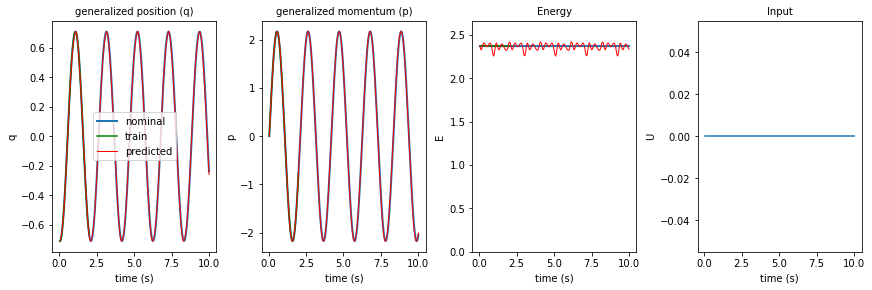

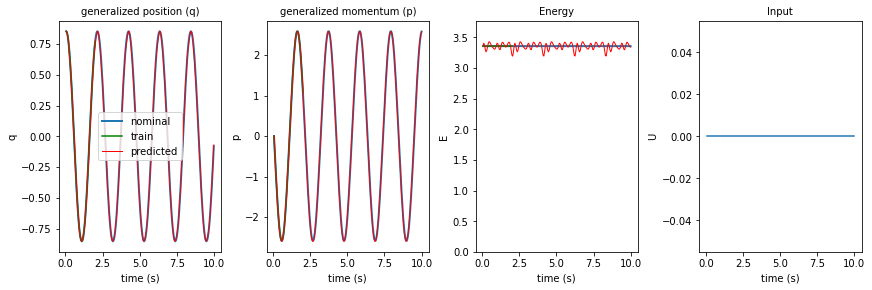

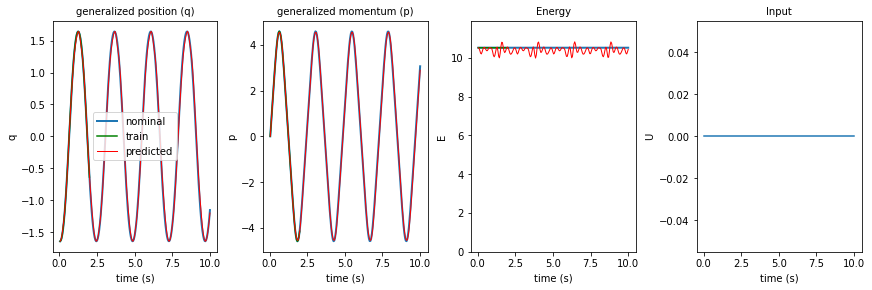

In [12]:
u_func_none = U_FUNC(utype=None)

model_training.u_func = U_FUNC(utype=None)

model_training.time_steps = 200
model_training.num_trajectories = 20
model_training.batch_size = 100
model_training.proportion = 0.0

model_training._init_data_loaders()

title = ""
for n in [0, 5, 15]:
    plot_results(
        model_training,
        n,
        train_horizon,
        file_path=model_training.plot_path + "noinput_simple_pend" + str(n) + ".png",
        show_pred=True,
        title=title,
        coord_type="hamiltonian",
    )

Generating dataset
Dataset created


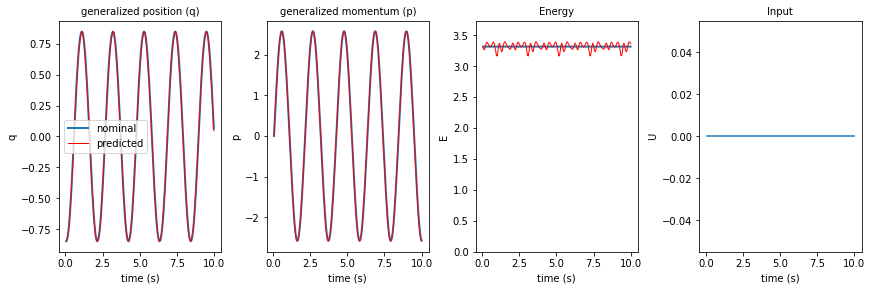

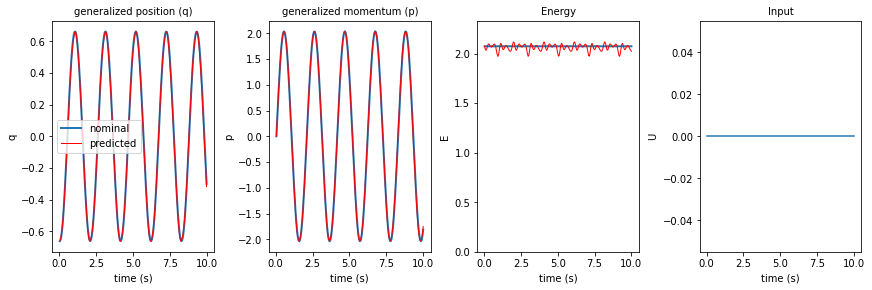

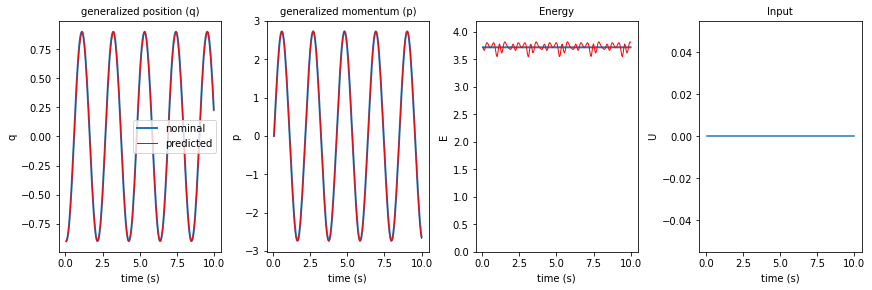

In [13]:
utype = "sine"
u_func = U_FUNC(utype=utype)
u_func.params["T"] = 2.0
u_func.params["f0"] = 0
u_func.params["f1"] = 1
u_func.params["scale"] = 0.5
gtype = "simple"
g_func = G_FUNC(device, gtype=gtype)

model_training.u_func = u_func
model_training.g_func = g_func

model_training.time_steps = 200
model_training.num_trajectories = 25
model_training.batch_size = 100
model_training.proportion = 0.0

model_training._init_data_loaders()

title = ""
for n in [0, 10, 20]:
    plot_results(
        model_training,
        n,
        train_horizon,
        file_path=model_training.plot_path + "1hz_simple_pend" + str(n) + ".png",
        show_pred=False,
        only_pred=True,
        title=title,
        coord_type="hamiltonian",
    )

## Input_HNN

### G is known

In [16]:
set_all_seeds(manualSeed=123, new_results=False)

device = set_device()

model_training = Training(
    PATH,
    device,
    w=[1.0, 1.0],
    resnet_config=False,
    horizon=False,
    horizon_type="auto",
    horizon_list=[20, 25, 30, 35, 40],
    switch_steps=[100, 100, 100, 100, 100],
    epoch_num=None,
    loss_type="L2weighted",
    test_every=5,
    print_every=1,
    lr=1e-3,
    weight_decay=1e-4,
    model_name="Input_HNN_chirp",
    time_steps=200,
    num_trajectories=125,
    batch_size=100,
    proportion=0.8,
    utype="chirp",
    gtype="simple",
    shuffle=False,
    coord_type="hamiltonian",
    save_suffix="",
)

Random Seed:  123
Available device: cpu
Number of training epochs:  500
Paths created
Model initiatialized 
Number of parameters: 7562


In [17]:
model_training._init_data_loaders()
stats = model_training.train()

Generating dataset
Dataset created
horizon length : 20
[  0/500]	 train loss: 7.106151e+00, t_train: 0.25, test loss: 6.694200e+00, t_test: 0.10
[  1/500]	 train loss: 6.928905e+00, t_train: 0.28
[  2/500]	 train loss: 6.752135e+00, t_train: 0.31
[  3/500]	 train loss: 6.573822e+00, t_train: 0.31
[  4/500]	 train loss: 6.392090e+00, t_train: 0.31
[  5/500]	 train loss: 6.205629e+00, t_train: 0.28, test loss: 5.793124e+00, t_test: 0.11
[  6/500]	 train loss: 6.014292e+00, t_train: 0.27
[  7/500]	 train loss: 5.819270e+00, t_train: 0.30
[  8/500]	 train loss: 5.622660e+00, t_train: 0.29
[  9/500]	 train loss: 5.426832e+00, t_train: 0.28
[ 10/500]	 train loss: 5.233742e+00, t_train: 0.31, test loss: 4.979565e+00, t_test: 0.09
[ 11/500]	 train loss: 5.044352e+00, t_train: 0.29
[ 12/500]	 train loss: 4.858425e+00, t_train: 0.30
[ 13/500]	 train loss: 4.674624e+00, t_train: 0.30
[ 14/500]	 train loss: 4.490919e+00, t_train: 0.28
[ 15/500]	 train loss: 4.305247e+00, t_train: 0.35, test loss: 

In [18]:
# save training class that contains dataset and model
pickle_save(model_training, model_training.model_path + "model.pkl")

In [19]:
# load the model
model_training = pickle_load(model_training.model_path + "model.pkl")

#### plots

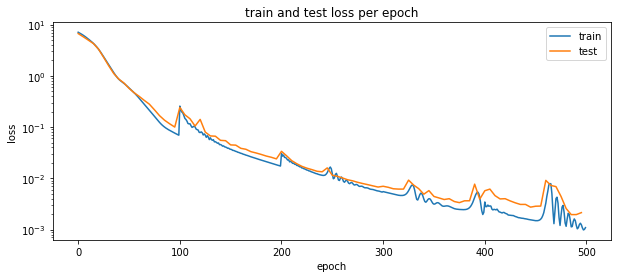

In [20]:
loss_train = model_training.logs["train_loss"]
loss_test = model_training.logs["test_loss"]
epochs = np.arange(len(loss_train))
train_test_loss_plot(
    loss_train,
    loss_test,
    epochs,
    model_training.test_epochs,
    file_path=model_training.plot_path + "simple_pend_losses.png",
    horizons=None,
    horizon_steps=[200, 400, 550, 700, 850],
    title="train and test loss per epoch",
)

In [21]:
train_horizon = model_training.horizon_list[-1]
print(train_horizon)

40


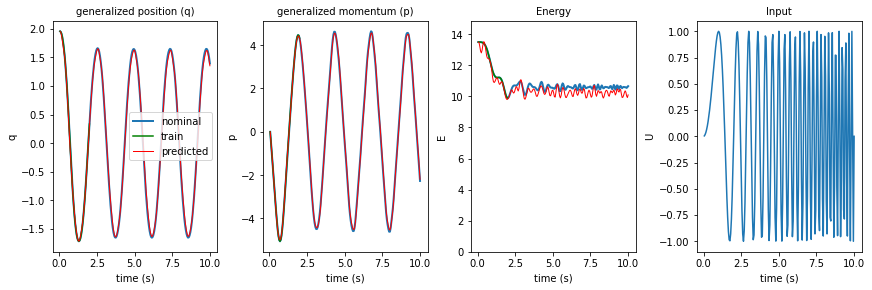

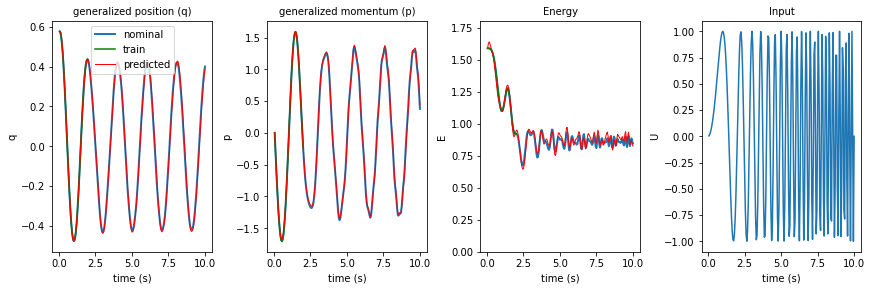

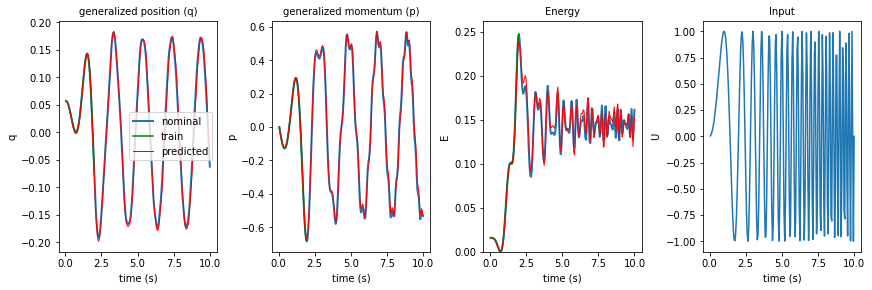

In [22]:
title = ""
for n in [5, 10, 75]:
    plot_results(
        model_training,
        n,
        train_horizon,
        file_path=model_training.plot_path + "simple_pend_train" + str(n) + ".png",
        show_pred=True,
        title=title,
        coord_type="hamiltonian",
    )

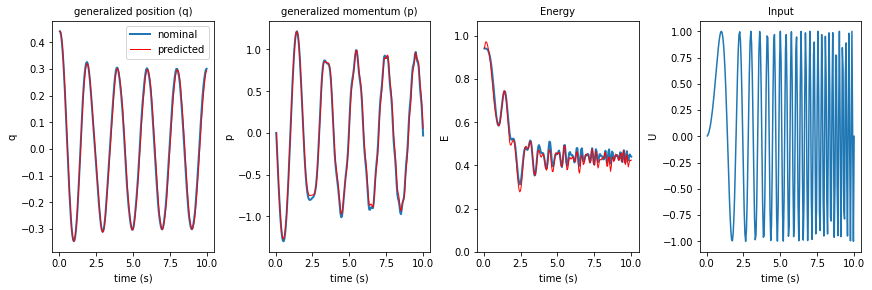

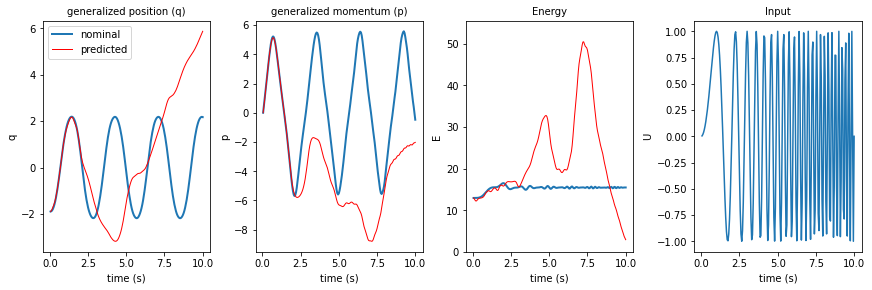

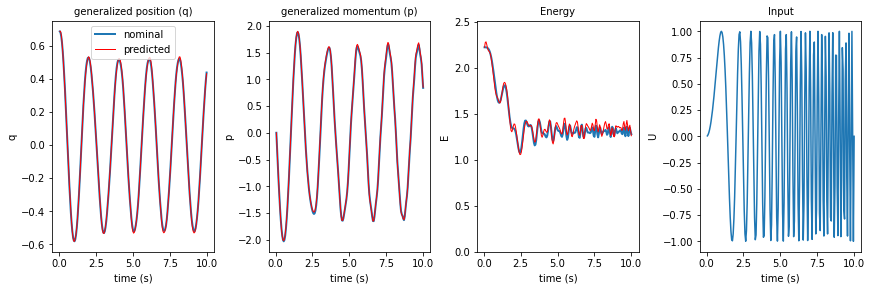

In [23]:
title = ""
for n in [5, 10, 15]:
    plot_results(
        model_training,
        n,
        train_horizon,
        train=False,
        file_path=model_training.plot_path + "simple_pend_test" + str(n) + ".png",
        only_pred=True,
        title=title,
        coord_type="hamiltonian",
    )

Random Seed:  123
Generating dataset
Dataset created


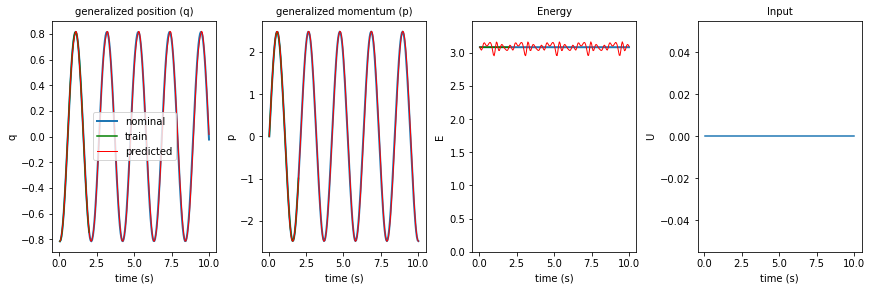

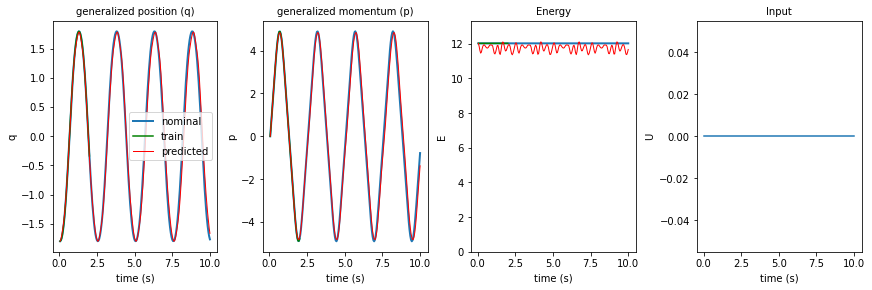

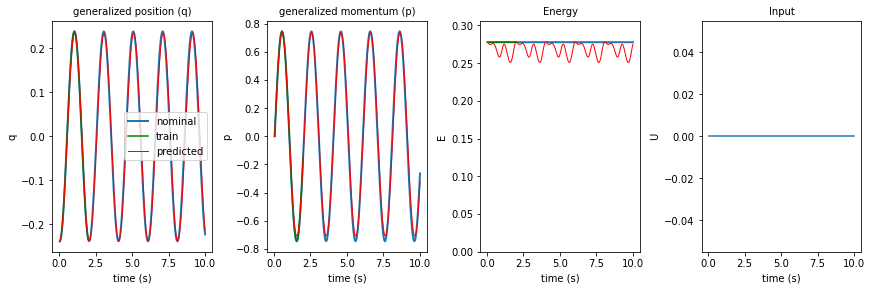

In [24]:
set_all_seeds(manualSeed=123, new_results=False)

model_training.model.u_func = U_FUNC(utype=None)
model_training.model.G_net = G_FUNC(device, gtype=None)


model_training.time_steps = 200
model_training.num_trajectories = 25
model_training.batch_size = 100
model_training.proportion = 0.0
model_training._init_data_loaders()

title = ""
for n in [0, 5, 15]:
    plot_results(
        model_training,
        n,
        train_horizon,
        train=True,
        file_path=model_training.plot_path + "noinput_simple_pend" + str(n) + ".png",
        show_pred=True,
        title=title,
        coord_type="hamiltonian",
    )

Generating dataset
Dataset created


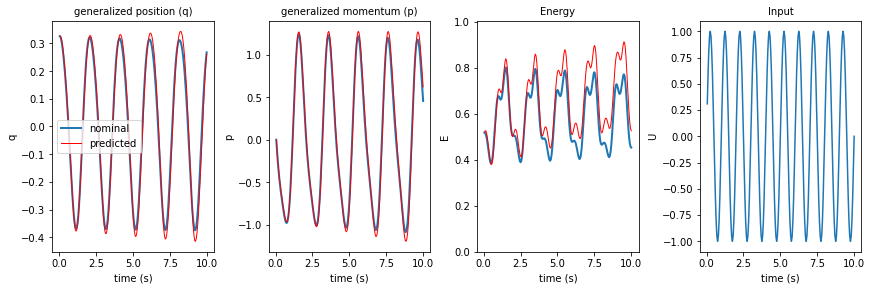

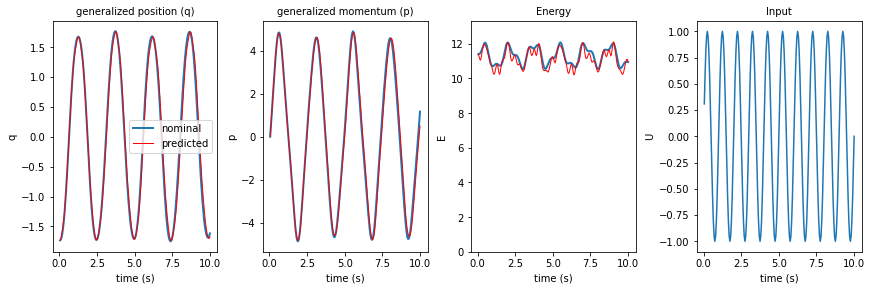

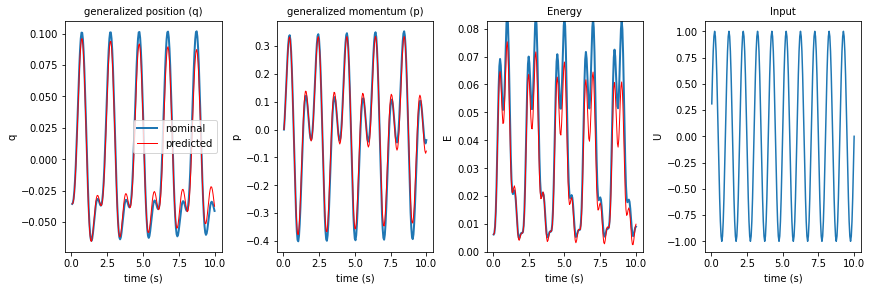

In [25]:
utype = "sine"
u_func = U_FUNC(utype=utype)
u_func.params["T"] = 2.0
u_func.params["f0"] = 0
u_func.params["f1"] = 1
u_func.params["scale"] = 1
gtype = "simple"
g_func = G_FUNC(device, gtype=gtype)

model_training.model.u_func = u_func
model_training.model.G_net = g_func

model_training.time_steps = 200
model_training.num_trajectories = 25
model_training.batch_size = 100
model_training.proportion = 0.0

model_training._init_data_loaders()

title = ""
for n in [0, 10, 20]:
    plot_results(
        model_training,
        n,
        train_horizon,
        file_path=model_training.plot_path + "1hz_simple_pend" + str(n) + ".png",
        show_pred=False,
        only_pred=True,
        title=title,
        coord_type="hamiltonian",
    )

Generating dataset
Dataset created


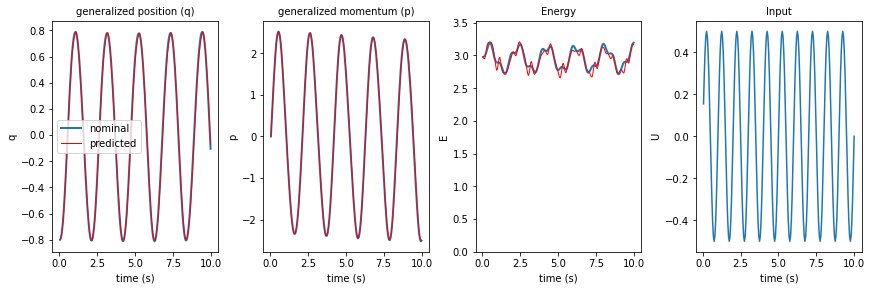

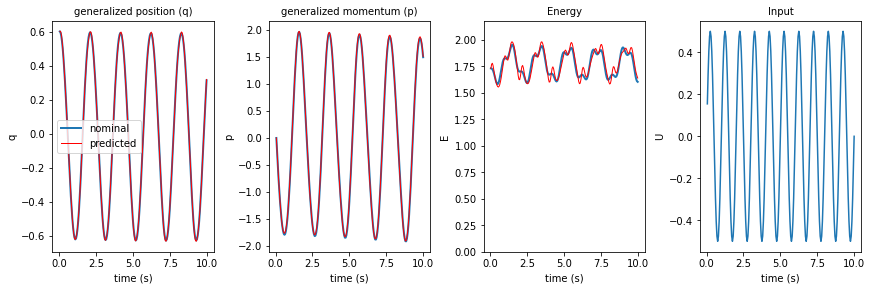

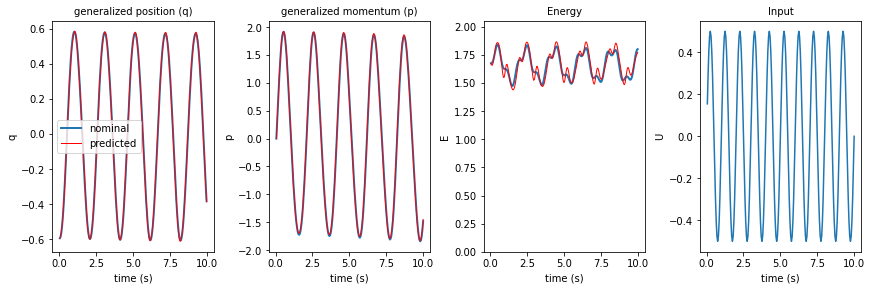

In [26]:
utype = "sine"
u_func = U_FUNC(utype=utype)
u_func.params["T"] = 2.0
u_func.params["f0"] = 0
u_func.params["f1"] = 1
u_func.params["scale"] = 0.5
gtype = "simple"
g_func = G_FUNC(device, gtype=gtype)

model_training.model.u_func = u_func
model_training.model.G_net = g_func

model_training.time_steps = 200
model_training.num_trajectories = 25
model_training.batch_size = 100
model_training.proportion = 0.0

model_training._init_data_loaders()

title = ""
for n in [0, 10, 20]:
    plot_results(
        model_training,
        n,
        train_horizon,
        file_path=model_training.plot_path + "0.5hz_simple_pend" + str(n) + ".png",
        show_pred=False,
        only_pred=True,
        title=title,
        coord_type="hamiltonian",
    )

### G is known but no horizon

In [27]:
set_all_seeds(manualSeed=123, new_results=False)

device = set_device()

model_training = Training(
    PATH,
    device,
    w=[1.0, 1.0],
    resnet_config=False,
    horizon=False,
    horizon_type="auto",
    horizon_list=[40, 40, 40, 40, 40],
    switch_steps=[100, 100, 100, 100, 100],
    epoch_num=None,
    loss_type="L2weighted",
    test_every=5,
    print_every=1,
    lr=1e-3,
    weight_decay=1e-4,
    model_name="Input_HNN_chirp_nohorizon",
    time_steps=200,
    num_trajectories=125,
    batch_size=100,
    proportion=0.8,
    utype="chirp",
    gtype="simple",
    shuffle=False,
    coord_type="hamiltonian",
    save_suffix="",
)

Random Seed:  123
Available device: cpu
Number of training epochs:  500
Paths created
Model initiatialized 
Number of parameters: 7562


In [28]:
model_training._init_data_loaders()
stats = model_training.train()

Generating dataset
Dataset created
horizon length : 40
[  0/500]	 train loss: 7.778563e+00, t_train: 0.49, test loss: 7.562387e+00, t_test: 0.21
[  1/500]	 train loss: 7.589475e+00, t_train: 0.58
[  2/500]	 train loss: 7.411458e+00, t_train: 0.56
[  3/500]	 train loss: 7.239840e+00, t_train: 0.54
[  4/500]	 train loss: 7.070948e+00, t_train: 0.56
[  5/500]	 train loss: 6.902228e+00, t_train: 0.58, test loss: 6.718637e+00, t_test: 0.24
[  6/500]	 train loss: 6.732443e+00, t_train: 0.60
[  7/500]	 train loss: 6.561661e+00, t_train: 0.56
[  8/500]	 train loss: 6.391143e+00, t_train: 0.56
[  9/500]	 train loss: 6.222973e+00, t_train: 0.58
[ 10/500]	 train loss: 6.059312e+00, t_train: 0.59, test loss: 5.963116e+00, t_test: 0.21
[ 11/500]	 train loss: 5.901155e+00, t_train: 0.59
[ 12/500]	 train loss: 5.747159e+00, t_train: 0.57
[ 13/500]	 train loss: 5.593779e+00, t_train: 0.54
[ 14/500]	 train loss: 5.437839e+00, t_train: 0.53
[ 15/500]	 train loss: 5.279925e+00, t_train: 0.55, test loss: 

In [29]:
# save training class that contains dataset and model
pickle_save(model_training, model_training.model_path + "model.pkl")

In [30]:
# load the model
model_training = pickle_load(model_training.model_path + "model.pkl")

#### plots

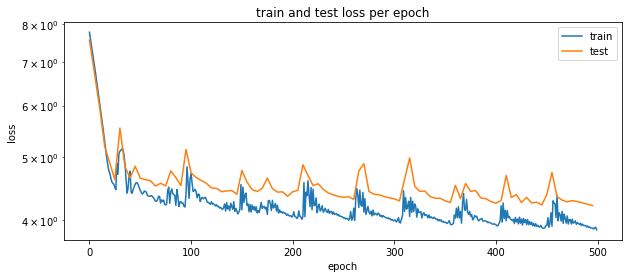

In [31]:
loss_train = model_training.logs["train_loss"]
loss_test = model_training.logs["test_loss"]
epochs = np.arange(len(loss_train))
train_test_loss_plot(
    loss_train,
    loss_test,
    epochs,
    model_training.test_epochs,
    file_path=model_training.plot_path + "simple_pend_losses.png",
    horizons=None,
    horizon_steps=[200, 400, 550, 700, 850],
    title="train and test loss per epoch",
)

In [32]:
train_horizon = model_training.horizon_list[-1]
print(train_horizon)

40


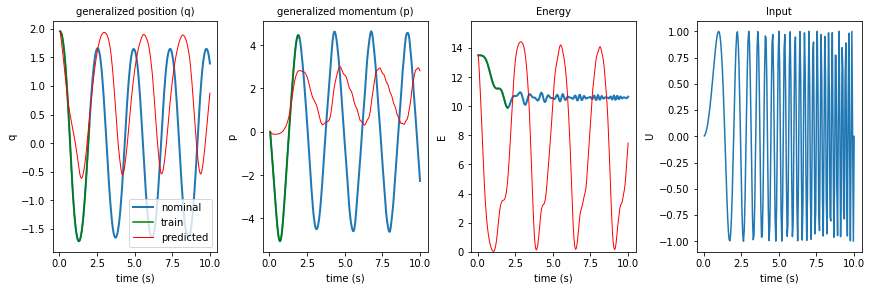

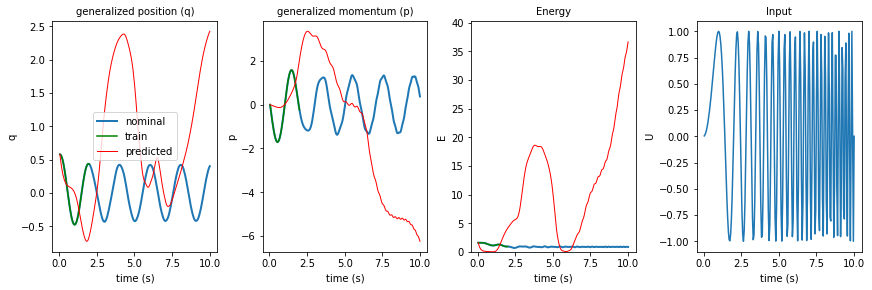

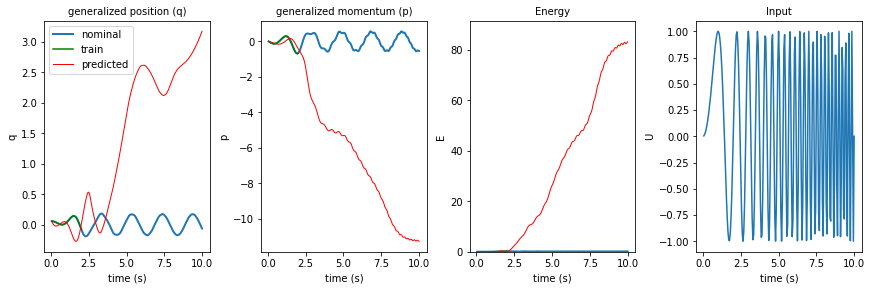

In [33]:
title = ""
for n in [5, 10, 75]:
    plot_results(
        model_training,
        n,
        train_horizon,
        file_path=model_training.plot_path + "simple_pend_train" + str(n) + ".png",
        show_pred=True,
        title=title,
        coord_type="hamiltonian",
    )

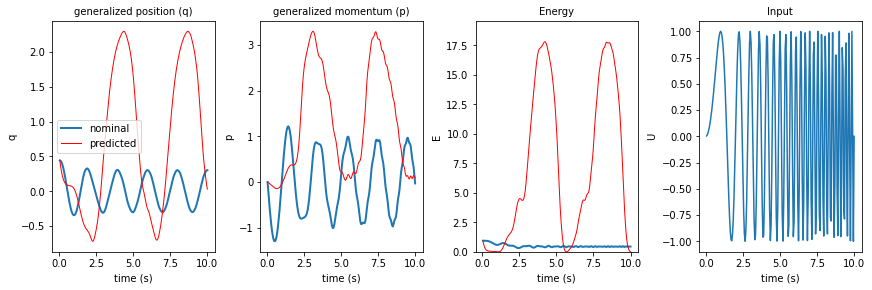

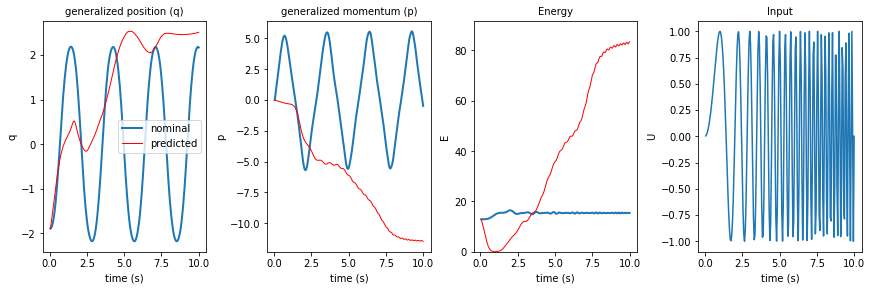

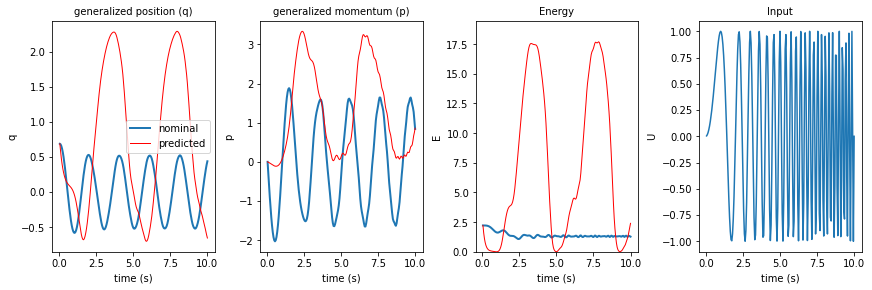

In [34]:
title = ""
for n in [5, 10, 15]:
    plot_results(
        model_training,
        n,
        train_horizon,
        train=False,
        file_path=model_training.plot_path + "simple_pend_test" + str(n) + ".png",
        only_pred=True,
        title=title,
        coord_type="hamiltonian",
    )

Random Seed:  123
Generating dataset
Dataset created


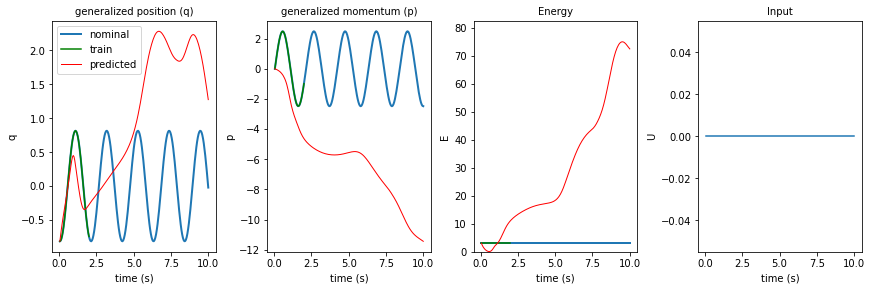

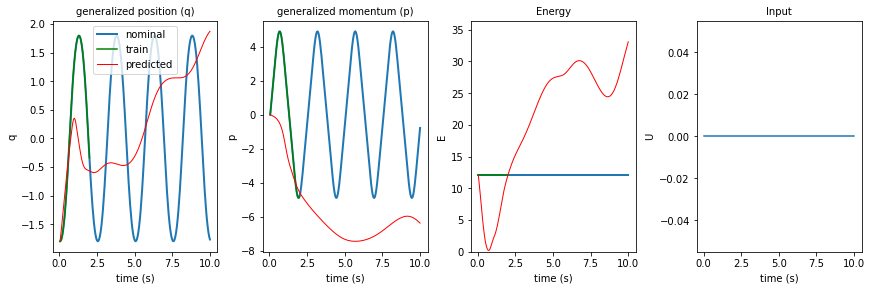

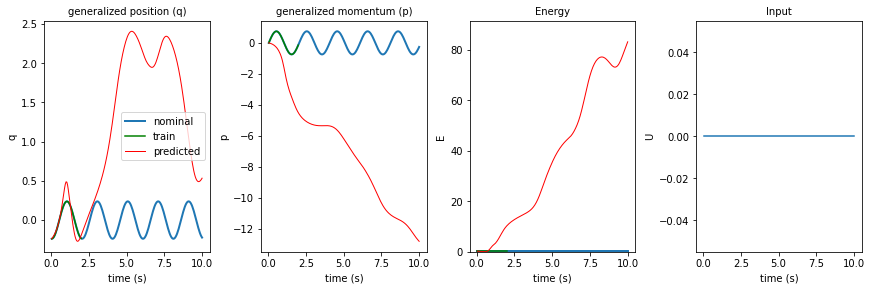

In [35]:
set_all_seeds(manualSeed=123, new_results=False)

model_training.model.u_func = U_FUNC(utype=None)
model_training.model.G_net = G_FUNC(device, gtype=None)
model_training.time_steps = 200
model_training.num_trajectories = 25
model_training.batch_size = 100
model_training.proportion = 0.0
model_training._init_data_loaders()

title = ""
for n in [0, 5, 15]:
    plot_results(
        model_training,
        n,
        train_horizon,
        train=True,
        file_path=model_training.plot_path + "noinput_simple_pend" + str(n) + ".png",
        show_pred=True,
        title=title,
        coord_type="hamiltonian",
    )

Generating dataset
Dataset created


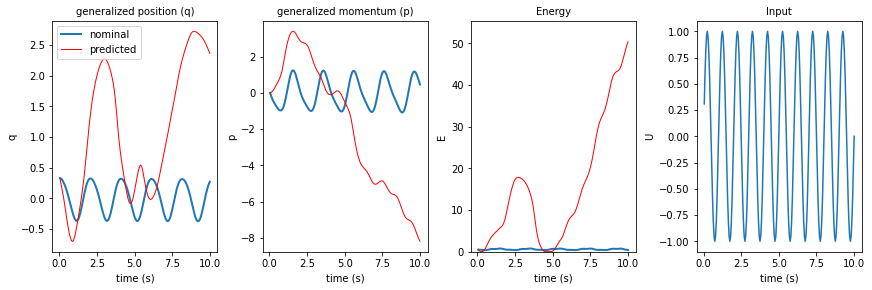

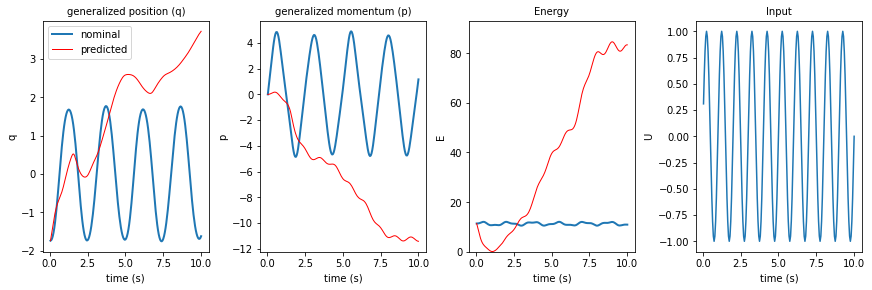

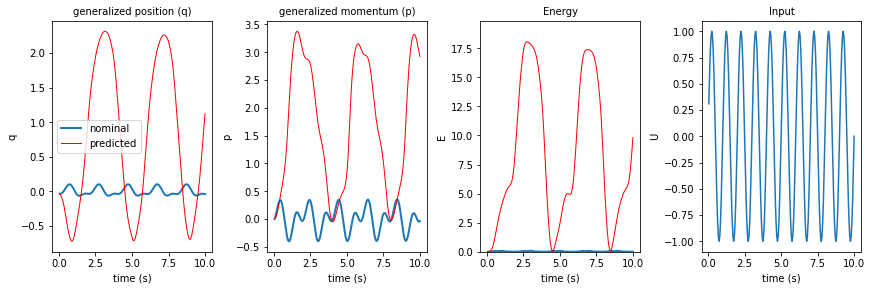

In [36]:
utype = "sine"
u_func = U_FUNC(utype=utype)
u_func.params["T"] = 2.0
u_func.params["f0"] = 0
u_func.params["f1"] = 1
u_func.params["scale"] = 1
gtype = "simple"
g_func = G_FUNC(device, gtype=gtype)

model_training.model.u_func = u_func
model_training.model.G_net = g_func

model_training.time_steps = 200
model_training.num_trajectories = 25
model_training.batch_size = 100
model_training.proportion = 0.0

model_training._init_data_loaders()

title = ""
for n in [0, 10, 20]:
    plot_results(
        model_training,
        n,
        train_horizon,
        file_path=model_training.plot_path + "1hz_simple_pend" + str(n) + ".png",
        show_pred=False,
        only_pred=True,
        title=title,
        coord_type="hamiltonian",
    )

Generating dataset
Dataset created


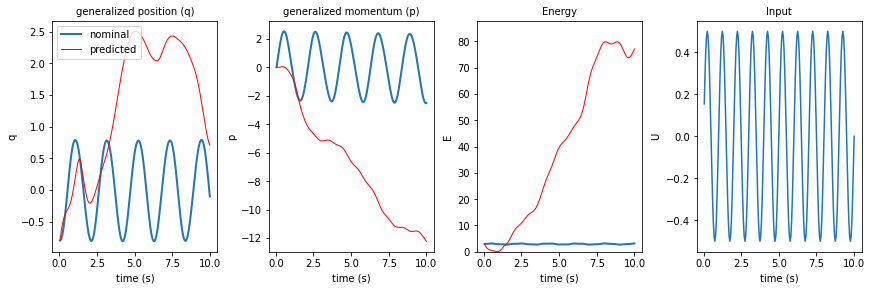

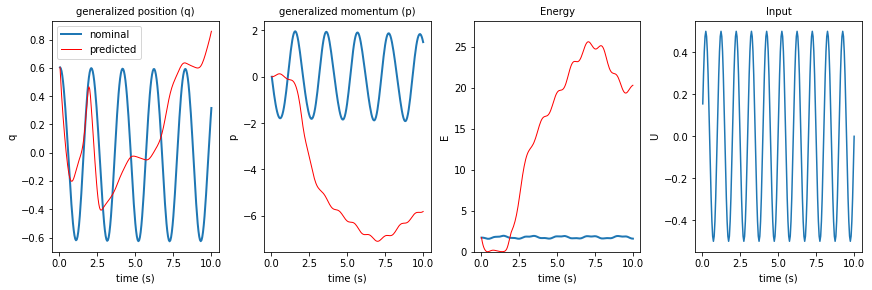

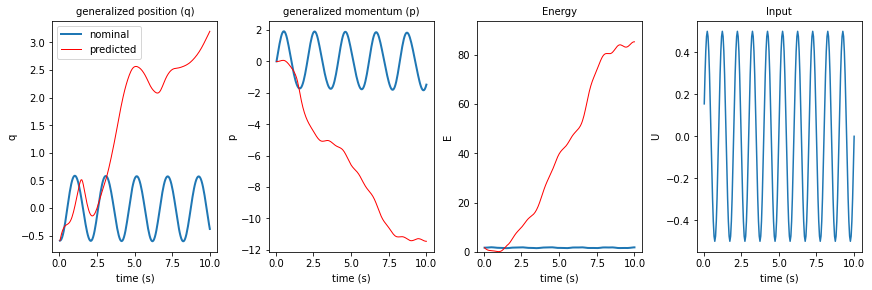

In [37]:
utype = "sine"
u_func = U_FUNC(utype=utype)
u_func.params["T"] = 2.0
u_func.params["f0"] = 0
u_func.params["f1"] = 1
u_func.params["scale"] = 0.5
gtype = "simple"
g_func = G_FUNC(device, gtype=gtype)

model_training.model.u_func = u_func
model_training.model.G_net = g_func

model_training.time_steps = 200
model_training.num_trajectories = 25
model_training.batch_size = 100
model_training.proportion = 0.0

model_training._init_data_loaders()

title = ""
for n in [0, 10, 20]:
    plot_results(
        model_training,
        n,
        train_horizon,
        file_path=model_training.plot_path + "0.5hz_simple_pend" + str(n) + ".png",
        show_pred=False,
        only_pred=True,
        title=title,
        coord_type="hamiltonian",
    )

### G is an NN

In [38]:
set_all_seeds(manualSeed=123, new_results=False)

device = set_device()

model_training = Training(
    PATH,
    device,
    w=[1.0, 1.0],
    resnet_config=False,
    horizon=False,
    horizon_type="auto",
    horizon_list=[20, 25, 30, 35, 40],
    switch_steps=[100, 100, 100, 100, 100],
    epoch_num=None,
    loss_type="L2weighted",
    test_every=5,
    print_every=1,
    lr=1e-3,
    weight_decay=1e-4,
    model_name="Input_HNN_chirp_GNN",
    time_steps=200,
    num_trajectories=125,
    batch_size=100,
    proportion=0.8,
    utype="chirp",
    gtype="simple",
    shuffle=False,
    coord_type="hamiltonian",
    save_suffix="",
)

Random Seed:  123
Available device: cpu
Number of training epochs:  500
Paths created
Model initiatialized 
Number of parameters: 8644


In [39]:
model_training._init_data_loaders()
stats = model_training.train()

Generating dataset
Dataset created
horizon length : 20
[  0/500]	 train loss: 6.961323e+00, t_train: 0.28, test loss: 6.623664e+00, t_test: 0.08
[  1/500]	 train loss: 6.752810e+00, t_train: 0.30
[  2/500]	 train loss: 6.546773e+00, t_train: 0.26
[  3/500]	 train loss: 6.341068e+00, t_train: 0.30
[  4/500]	 train loss: 6.133943e+00, t_train: 0.31
[  5/500]	 train loss: 5.924277e+00, t_train: 0.29, test loss: 5.660405e+00, t_test: 0.13
[  6/500]	 train loss: 5.712303e+00, t_train: 0.27
[  7/500]	 train loss: 5.499820e+00, t_train: 0.27
[  8/500]	 train loss: 5.289556e+00, t_train: 0.28
[  9/500]	 train loss: 5.084218e+00, t_train: 0.25
[ 10/500]	 train loss: 4.885584e+00, t_train: 0.27, test loss: 4.656990e+00, t_test: 0.08
[ 11/500]	 train loss: 4.693927e+00, t_train: 0.27
[ 12/500]	 train loss: 4.507945e+00, t_train: 0.28
[ 13/500]	 train loss: 4.325209e+00, t_train: 0.29
[ 14/500]	 train loss: 4.142853e+00, t_train: 0.23
[ 15/500]	 train loss: 3.958337e+00, t_train: 0.27, test loss: 

In [40]:
# save training class that contains dataset and model
pickle_save(model_training, model_training.model_path + "model.pkl")

In [41]:
# load the model
model_training = pickle_load(model_training.model_path + "model.pkl")

#### plots

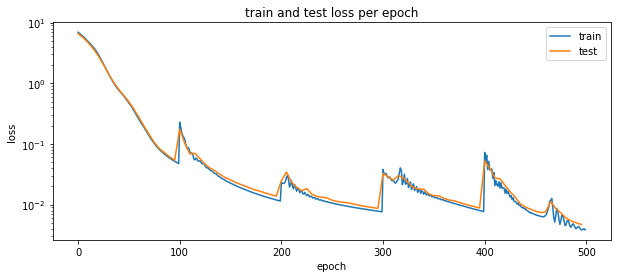

In [42]:
loss_train = model_training.logs["train_loss"]
loss_test = model_training.logs["test_loss"]
epochs = np.arange(len(loss_train))
train_test_loss_plot(
    loss_train,
    loss_test,
    epochs,
    model_training.test_epochs,
    file_path=model_training.plot_path + "simple_pend_losses.png",
    horizons=None,
    horizon_steps=[200, 400, 550, 700, 850],
    title="train and test loss per epoch",
)

In [43]:
train_horizon = model_training.horizon_list[-1]
print(train_horizon)

40


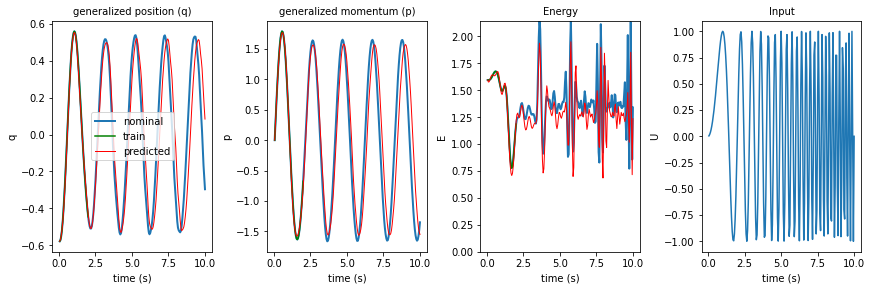

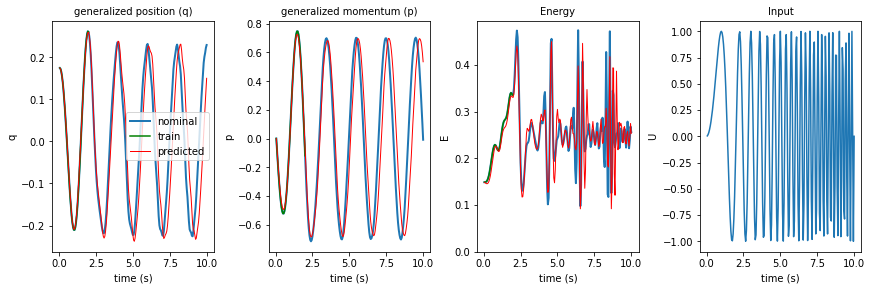

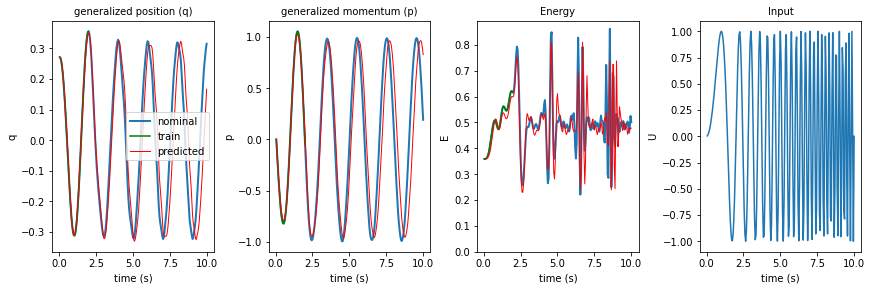

In [44]:
title = ""
for n in [5, 10, 75]:
    plot_results(
        model_training,
        n,
        train_horizon,
        file_path=model_training.plot_path + "simple_pend_train" + str(n) + ".png",
        show_pred=True,
        title=title,
        coord_type="hamiltonian",
    )

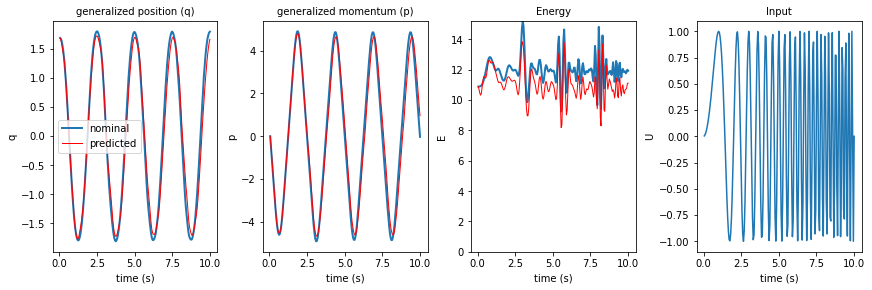

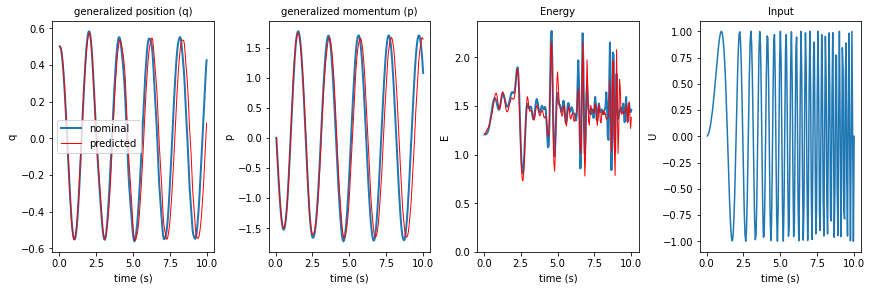

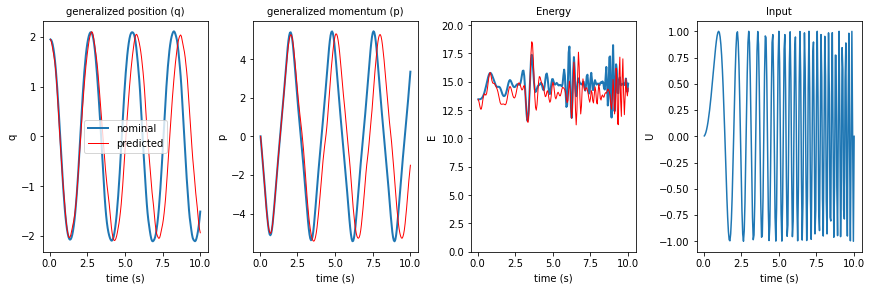

In [45]:
title = ""
for n in [5, 10, 15]:
    plot_results(
        model_training,
        n,
        train_horizon,
        train=False,
        file_path=model_training.plot_path + "simple_pend_test" + str(n) + ".png",
        only_pred=True,
        title=title,
        coord_type="hamiltonian",
    )

Random Seed:  123
Generating dataset
Dataset created


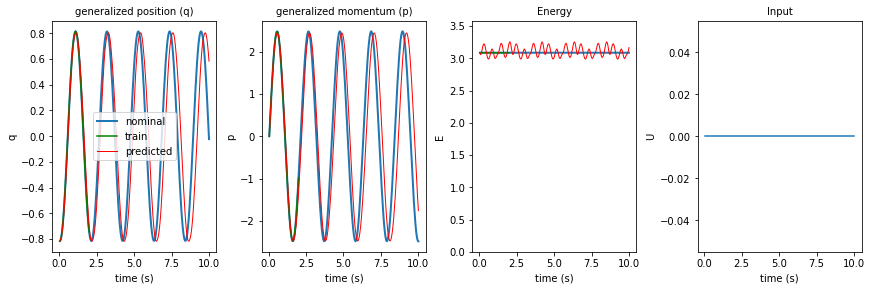

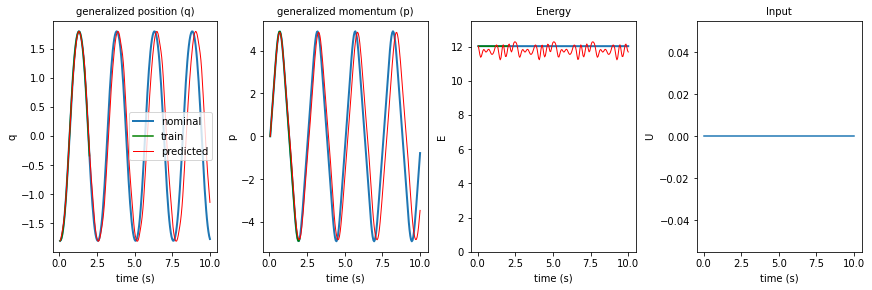

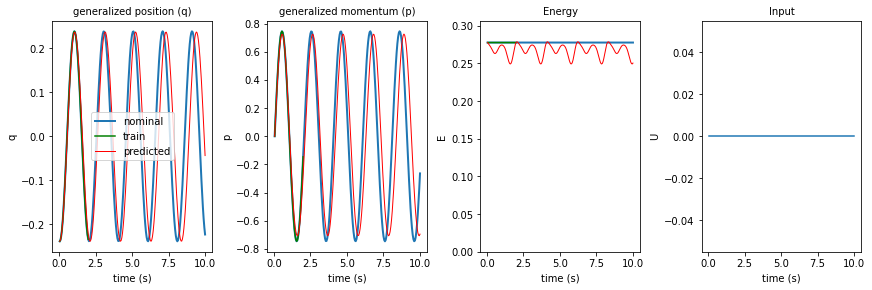

In [48]:
set_all_seeds(manualSeed=123, new_results=False)

model_training.model.u_func = U_FUNC(utype=None)
del model_training.model.G_net # required because pytorch won't let you replace an nn.module with another class
model_training.model.G_net = G_FUNC(device, gtype=None)
model_training.time_steps = 200
model_training.num_trajectories = 25
model_training.batch_size = 100
model_training.proportion = 0.0
model_training._init_data_loaders()

title = ""
for n in [0, 5, 15]:
    plot_results(
        model_training,
        n,
        train_horizon,
        train=True,
        file_path=model_training.plot_path + "noinput_simple_pend" + str(n) + ".png",
        show_pred=True,
        title=title,
        coord_type="hamiltonian",
    )

Generating dataset
Dataset created


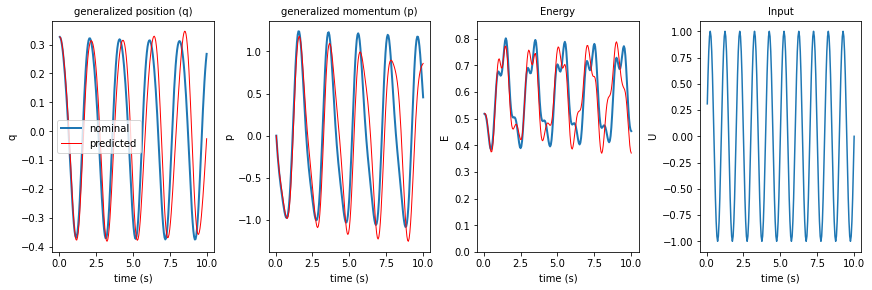

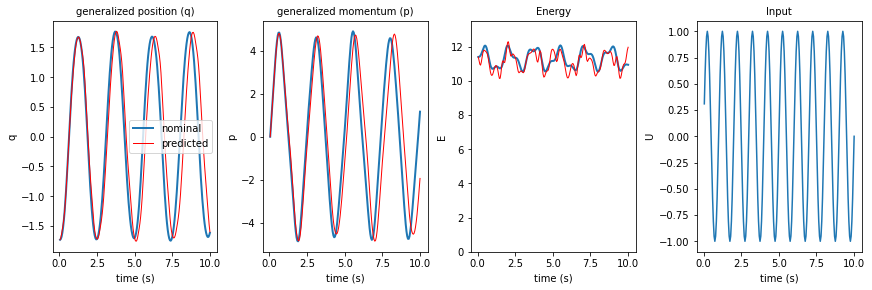

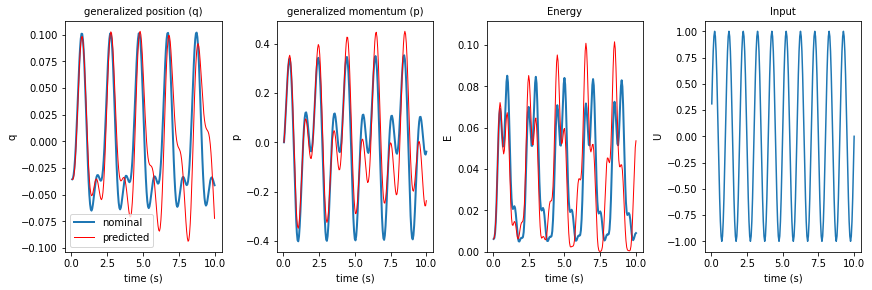

In [49]:
utype = "sine"
u_func = U_FUNC(utype=utype)
u_func.params["T"] = 2.0
u_func.params["f0"] = 0
u_func.params["f1"] = 1
u_func.params["scale"] = 1
gtype = "simple"
g_func = G_FUNC(device, gtype=gtype)

model_training.model.u_func = u_func
del model_training.model.G_net
model_training.model.G_net = g_func

model_training.time_steps = 200
model_training.num_trajectories = 25
model_training.batch_size = 100
model_training.proportion = 0.0

model_training._init_data_loaders()

title = ""
for n in [0, 10, 20]:
    plot_results(
        model_training,
        n,
        train_horizon,
        file_path=model_training.plot_path + "1hz_simple_pend" + str(n) + ".png",
        show_pred=False,
        only_pred=True,
        title=title,
        coord_type="hamiltonian",
    )

Generating dataset
Dataset created


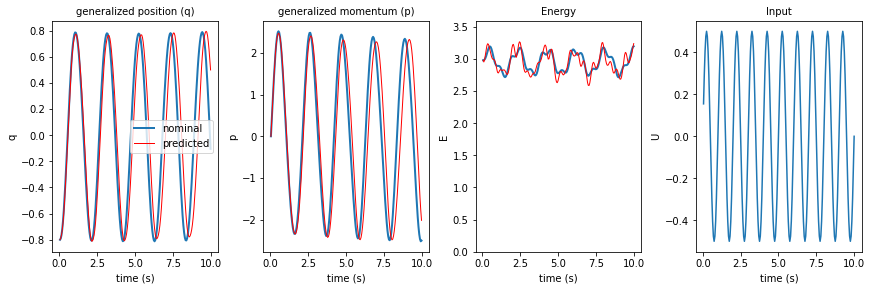

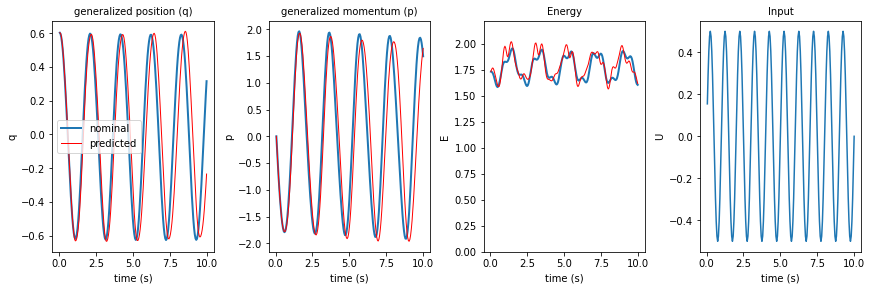

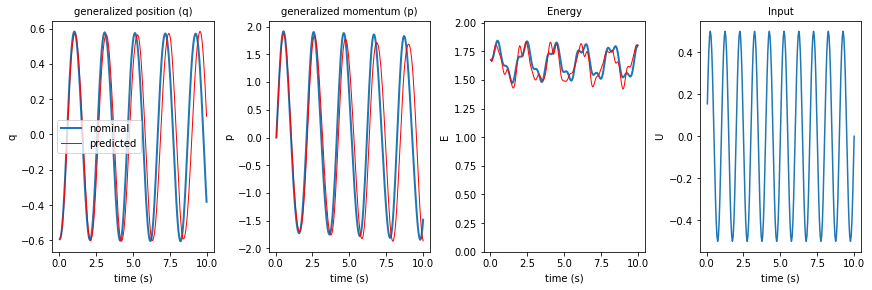

In [50]:
utype = "sine"
u_func = U_FUNC(utype=utype)
u_func.params["T"] = 2.0
u_func.params["f0"] = 0
u_func.params["f1"] = 1
u_func.params["scale"] = 0.5
gtype = "simple"
g_func = G_FUNC(device, gtype=gtype)

model_training.model.u_func = u_func
del model_training.model.G_net
model_training.model.G_net = g_func

model_training.time_steps = 200
model_training.num_trajectories = 25
model_training.batch_size = 100
model_training.proportion = 0.0

model_training._init_data_loaders()

title = ""
for n in [0, 10, 20]:
    plot_results(
        model_training,
        n,
        train_horizon,
        file_path=model_training.plot_path + "0.5hz_simple_pend" + str(n) + ".png",
        show_pred=False,
        only_pred=True,
        title=title,
        coord_type="hamiltonian",
    )

## Expanding_HNN

In [51]:
set_all_seeds(manualSeed=123, new_results=False)

device = set_device()

model_training = Training(
    PATH,
    device,
    w=[1.0, 1.0],
    resnet_config=1,
    horizon=False,
    horizon_type="auto",
    horizon_list=[20, 25, 30, 35, 40],
    switch_steps=[100, 100, 100, 100, 100],
    epoch_num=None,
    loss_type="L2weighted",
    test_every=5,
    print_every=1,
    lr=1e-3,
    weight_decay=1e-4,
    model_name="Expanding_HNN_chirp",
    time_steps=200,
    num_trajectories=125,
    batch_size=100,
    proportion=0.8,
    utype="chirp",
    gtype="simple",
    shuffle=False,
    coord_type="hamiltonian",
    save_suffix="",
)

Random Seed:  123
Available device: cpu
Number of training epochs:  500
Paths created
mlp number of parameters : 1102
resblock number of parameters : 1079
Total number of H_net parameters : 7576
Model initiatialized 
Number of parameters: 1102


In [52]:
model_training._init_data_loaders()
stats = model_training.train()

Generating dataset


In [ ]:
# save training class that contains dataset and model
pickle_save(model_training, model_training.model_path + "model.pkl")

In [ ]:
# load the model
model_training = pickle_load(model_training.model_path + "model.pkl")

#### plots

In [ ]:
loss_train = model_training.logs["train_loss"]
loss_test = model_training.logs["test_loss"]
epochs = np.arange(len(loss_train))
train_test_loss_plot(
    loss_train,
    loss_test,
    epochs,
    model_training.test_epochs,
    file_path=model_training.plot_path + "simple_pend_losses.png",
    horizons=None,
    horizon_steps=[200, 400, 550, 700, 850],
    title="train and test loss per epoch",
)

In [ ]:
train_horizon = model_training.horizon_list[-1]
print(train_horizon)

In [ ]:
title = ""
for n in [5, 10, 75]:
    plot_results(
        model_training,
        n,
        train_horizon,
        file_path=model_training.plot_path + "simple_pend_train" + str(n) + ".png",
        show_pred=True,
        title=title,
        coord_type="hamiltonian",
    )

In [ ]:
title = ""
for n in [5, 10, 15]:
    plot_results(
        model_training,
        n,
        train_horizon,
        train=False,
        file_path=model_training.plot_path + "simple_pend_test" + str(n) + ".png",
        only_pred=True,
        title=title,
        coord_type="hamiltonian",
    )

In [ ]:
set_all_seeds(manualSeed=123, new_results=False)

model_training.model.u_func = U_FUNC(utype=None)
model_training.model.G_net = G_FUNC(device, gtype=None)
model_training.time_steps = 200
model_training.num_trajectories = 25
model_training.batch_size = 100
model_training.proportion = 0.0
model_training._init_data_loaders()

title = ""
for n in [0, 5, 15]:
    plot_results(
        model_training,
        n,
        train_horizon,
        train=True,
        file_path=model_training.plot_path + "noinput_simple_pend" + str(n) + ".png",
        show_pred=True,
        title=title,
        coord_type="hamiltonian",
    )

In [ ]:
utype = "sine"
u_func = U_FUNC(utype=utype)
u_func.params["T"] = 2.0
u_func.params["f0"] = 0
u_func.params["f1"] = 1
u_func.params["scale"] = 1
gtype = "simple"
g_func = G_FUNC(device, gtype=gtype)

model_training.model.u_func = u_func
model_training.model.G_net = g_func

model_training.time_steps = 200
model_training.num_trajectories = 25
model_training.batch_size = 100
model_training.proportion = 0.0

model_training._init_data_loaders()

title = ""
for n in [0, 10, 20]:
    plot_results(
        model_training,
        n,
        train_horizon,
        file_path=model_training.plot_path + "1hz_simple_pend" + str(n) + ".png",
        show_pred=False,
        only_pred=True,
        title=title,
        coord_type="hamiltonian",
    )

In [ ]:
utype = "sine"
u_func = U_FUNC(utype=utype)
u_func.params["T"] = 2.0
u_func.params["f0"] = 0
u_func.params["f1"] = 1
u_func.params["scale"] = 0.5
gtype = "simple"
g_func = G_FUNC(device, gtype=gtype)

model_training.model.u_func = u_func
model_training.model.G_net = g_func

model_training.time_steps = 200
model_training.num_trajectories = 25
model_training.batch_size = 100
model_training.proportion = 0.0

model_training._init_data_loaders()

title = ""
for n in [0, 10, 20]:
    plot_results(
        model_training,
        n,
        train_horizon,
        file_path=model_training.plot_path + "0.5hz_simple_pend" + str(n) + ".png",
        show_pred=False,
        only_pred=True,
        title=title,
        coord_type="hamiltonian",
    )

## Expanding_HNN_wide

In [ ]:
set_all_seeds(manualSeed=123, new_results=False)

device = set_device()

model_training = Training(
    PATH,
    device,
    w=[1.0, 1.0],
    resnet_config=1,
    horizon=False,
    horizon_type="auto",
    horizon_list=[20, 25, 30, 35, 40],
    switch_steps=[100, 100, 100, 100, 100],
    epoch_num=None,
    loss_type="L2weighted",
    test_every=5,
    print_every=1,
    lr=1e-3,
    weight_decay=1e-4,
    model_name="Expanding_wide_HNN_chirp",
    time_steps=200,
    num_trajectories=125,
    batch_size=100,
    proportion=0.8,
    utype="chirp",
    gtype="simple",
    shuffle=False,
    coord_type="hamiltonian",
    save_suffix="",
)

Random Seed:  123
Available device: cpu
Number of training epochs:  10
Generating dataset
Dataset created
Paths created


NameError: name 'device' is not defined

In [ ]:
model_training._init_data_loaders()
stats = model_training.train()

horizon length : 20
[  0/ 10]	 train loss: 7.484456e+00, t_train: 0.28, test loss: 6.907747e+00, t_test: 0.10
[  1/ 10]	 train loss: 7.260284e+00, t_train: 0.20
horizon length : 25
[  2/ 10]	 train loss: 6.942301e+00, t_train: 0.28
[  3/ 10]	 train loss: 6.752009e+00, t_train: 0.32
horizon length : 30
[  4/ 10]	 train loss: 6.855915e+00, t_train: 0.39
[  5/ 10]	 train loss: 6.694682e+00, t_train: 0.36, test loss: 6.182197e+00, t_test: 0.15
horizon length : 35
[  6/ 10]	 train loss: 7.371741e+00, t_train: 0.43
[  7/ 10]	 train loss: 7.205282e+00, t_train: 0.44
horizon length : 40
[  8/ 10]	 train loss: 7.719395e+00, t_train: 0.49
[  9/ 10]	 train loss: 7.509027e+00, t_train: 0.48


In [ ]:
# save training class that contains dataset and model
pickle_save(model_training, model_training.model_path + "model.pkl")

In [ ]:
# load the model
model_training = pickle_load(model_training.model_path + "model.pkl")

#### plots

In [ ]:
loss_train = model_training.logs["train_loss"]
loss_test = model_training.logs["test_loss"]
epochs = np.arange(len(loss_train))
train_test_loss_plot(
    loss_train,
    loss_test,
    epochs,
    model_training.test_epochs,
    file_path=model_training.plot_path + "simple_pend_losses.png",
    horizons=None,
    horizon_steps=[200, 400, 550, 700, 850],
    title="train and test loss per epoch",
)

In [ ]:
train_horizon = model_training.horizon_list[-1]
print(train_horizon)

In [ ]:
title = ""
for n in [5, 10, 75]:
    plot_results(
        model_training,
        n,
        train_horizon,
        file_path=model_training.plot_path + "simple_pend_train" + str(n) + ".png",
        show_pred=True,
        title=title,
        coord_type="hamiltonian",
    )

In [ ]:
title = ""
for n in [5, 10, 15]:
    plot_results(
        model_training,
        n,
        train_horizon,
        train=False,
        file_path=model_training.plot_path + "simple_pend_test" + str(n) + ".png",
        only_pred=True,
        title=title,
        coord_type="hamiltonian",
    )

In [ ]:
set_all_seeds(manualSeed=123, new_results=False)

model_training.model.u_func = U_FUNC(utype=None)
model_training.model.G_net = G_FUNC(device, gtype=None)
model_training.time_steps = 200
model_training.num_trajectories = 25
model_training.batch_size = 100
model_training.proportion = 0.0
model_training._init_data_loaders()

title = ""
for n in [0, 5, 15]:
    plot_results(
        model_training,
        n,
        train_horizon,
        train=True,
        file_path=model_training.plot_path + "noinput_simple_pend" + str(n) + ".png",
        show_pred=True,
        title=title,
        coord_type="hamiltonian",
    )

In [ ]:
utype = "sine"
u_func = U_FUNC(utype=utype)
u_func.params["T"] = 2.0
u_func.params["f0"] = 0
u_func.params["f1"] = 1
u_func.params["scale"] = 1
gtype = "simple"
g_func = G_FUNC(device, gtype=gtype)

model_training.model.u_func = u_func
model_training.model.G_net = g_func

model_training.time_steps = 200
model_training.num_trajectories = 25
model_training.batch_size = 100
model_training.proportion = 0.0

model_training._init_data_loaders()

title = ""
for n in [0, 10, 20]:
    plot_results(
        model_training,
        n,
        train_horizon,
        file_path=model_training.plot_path + "1hz_simple_pend" + str(n) + ".png",
        show_pred=False,
        only_pred=True,
        title=title,
        coord_type="hamiltonian",
    )

In [ ]:
utype = "sine"
u_func = U_FUNC(utype=utype)
u_func.params["T"] = 2.0
u_func.params["f0"] = 0
u_func.params["f1"] = 1
u_func.params["scale"] = 0.5
gtype = "simple"
g_func = G_FUNC(device, gtype=gtype)

model_training.model.u_func = u_func
model_training.model.G_net = g_func

model_training.time_steps = 200
model_training.num_trajectories = 25
model_training.batch_size = 100
model_training.proportion = 0.0

model_training._init_data_loaders()

title = ""
for n in [0, 10, 20]:
    plot_results(
        model_training,
        n,
        train_horizon,
        file_path=model_training.plot_path + "0.5hz_simple_pend" + str(n) + ".png",
        show_pred=False,
        only_pred=True,
        title=title,
        coord_type="hamiltonian",
    )

## Interp_HNN

In [ ]:
set_all_seeds(manualSeed=123, new_results=False)

device = set_device()

model_training = Training(
    PATH,
    device,
    w=[1.0, 1.0],
    resnet_config=2,
    horizon=False,
    horizon_type="auto",
    horizon_list=[40, 40, 40, 40, 40],
    switch_steps=[100, 100, 100, 100, 100],
    epoch_num=None,
    loss_type="L2weighted",
    test_every=5,
    print_every=1,
    lr=1e-3,
    weight_decay=1e-4,
    model_name="Interp_HNN_chirp",
    time_steps=200,
    num_trajectories=125,
    batch_size=100,
    proportion=0.8,
    utype="chirp",
    gtype="simple",
    shuffle=False,
    coord_type="hamiltonian",
    save_suffix="",
)

Random Seed:  123
Available device: cpu
Number of training epochs:  10
Generating dataset
Dataset created
Paths created
mlp number of parameters : 416
resblock number of parameters : 434
Total number of H_net parameters : 7794
Model initiatialized. 
 Number of parameters : 416


In [ ]:
model_training._init_data_loaders()
stats = model_training.train()

horizon length : 40
Model size increased
[  0/ 10]	 train loss: 6.530754e+00, t_train: 0.40, test loss: 8.455670e+00, t_test: 0.22
[  1/ 10]	 train loss: 6.467261e+00, t_train: 0.40
horizon length : 40
Model size increased
[  2/ 10]	 train loss: 6.336012e+00, t_train: 0.51
[  3/ 10]	 train loss: 6.276437e+00, t_train: 0.51
horizon length : 40
Model size increased
[  4/ 10]	 train loss: 6.185132e+00, t_train: 0.73
[  5/ 10]	 train loss: 6.128132e+00, t_train: 0.72, test loss: 7.993954e+00, t_test: 0.36
horizon length : 40
Model size increased
[  6/ 10]	 train loss: 6.057745e+00, t_train: 1.19
[  7/ 10]	 train loss: 6.002436e+00, t_train: 1.22
horizon length : 40
Model size increased
[  8/ 10]	 train loss: 5.920347e+00, t_train: 2.23
[  9/ 10]	 train loss: 5.867141e+00, t_train: 2.21


In [ ]:
# save training class that contains dataset and model
pickle_save(model_training, model_training.model_path + "model.pkl")

In [ ]:
# load the model
model_training = pickle_load(model_training.model_path + "model.pkl")

#### plots

In [ ]:
loss_train = model_training.logs["train_loss"]
loss_test = model_training.logs["test_loss"]
epochs = np.arange(len(loss_train))
train_test_loss_plot(
    loss_train,
    loss_test,
    epochs,
    model_training.test_epochs,
    file_path=model_training.plot_path + "simple_pend_losses.png",
    horizons=None,
    horizon_steps=[200, 400, 550, 700, 850],
    title="train and test loss per epoch",
)

In [ ]:
train_horizon = model_training.horizon_list[-1]
print(train_horizon)

In [ ]:
title = ""
for n in [5, 10, 75]:
    plot_results(
        model_training,
        n,
        train_horizon,
        file_path=model_training.plot_path + "simple_pend_train" + str(n) + ".png",
        show_pred=True,
        title=title,
        coord_type="hamiltonian",
    )

In [ ]:
title = ""
for n in [5, 10, 15]:
    plot_results(
        model_training,
        n,
        train_horizon,
        train=False,
        file_path=model_training.plot_path + "simple_pend_test" + str(n) + ".png",
        only_pred=True,
        title=title,
        coord_type="hamiltonian",
    )

In [ ]:
set_all_seeds(manualSeed=123, new_results=False)

model_training.model.u_func = U_FUNC(utype=None)
model_training.model.G_net = G_FUNC(device, gtype=None)
model_training.time_steps = 200
model_training.num_trajectories = 25
model_training.batch_size = 100
model_training.proportion = 0.0
model_training._init_data_loaders()

title = ""
for n in [0, 5, 15]:
    plot_results(
        model_training,
        n,
        train_horizon,
        train=True,
        file_path=model_training.plot_path + "noinput_simple_pend" + str(n) + ".png",
        show_pred=True,
        title=title,
        coord_type="hamiltonian",
    )

In [ ]:
utype = "sine"
u_func = U_FUNC(utype=utype)
u_func.params["T"] = 2.0
u_func.params["f0"] = 0
u_func.params["f1"] = 1
u_func.params["scale"] = 1
gtype = "simple"
g_func = G_FUNC(device, gtype=gtype)

model_training.model.u_func = u_func
model_training.model.G_net = g_func

model_training.time_steps = 200
model_training.num_trajectories = 25
model_training.batch_size = 100
model_training.proportion = 0.0

model_training._init_data_loaders()

title = ""
for n in [0, 10, 20]:
    plot_results(
        model_training,
        n,
        train_horizon,
        file_path=model_training.plot_path + "1hz_simple_pend" + str(n) + ".png",
        show_pred=False,
        only_pred=True,
        title=title,
        coord_type="hamiltonian",
    )

In [ ]:
utype = "sine"
u_func = U_FUNC(utype=utype)
u_func.params["T"] = 2.0
u_func.params["f0"] = 0
u_func.params["f1"] = 1
u_func.params["scale"] = 0.5
gtype = "simple"
g_func = G_FUNC(device, gtype=gtype)

model_training.model.u_func = u_func
model_training.model.G_net = g_func

model_training.time_steps = 200
model_training.num_trajectories = 25
model_training.batch_size = 100
model_training.proportion = 0.0

model_training._init_data_loaders()

title = ""
for n in [0, 10, 20]:
    plot_results(
        model_training,
        n,
        train_horizon,
        file_path=model_training.plot_path + "0.5hz_simple_pend" + str(n) + ".png",
        show_pred=False,
        only_pred=True,
        title=title,
        coord_type="hamiltonian",
    )

## Interp_horizon_HNN

In [ ]:
set_all_seeds(manualSeed=123, new_results=False)

device = set_device()

model_training = Training(
    PATH,
    device,
    w=[1.0, 1.0],
    resnet_config=2,
    horizon=False,
    horizon_type="auto",
    horizon_list=[20, 25, 30, 35, 40],
    switch_steps=[100, 100, 100, 100, 100],
    epoch_num=None,
    loss_type="L2weighted",
    test_every=5,
    print_every=1,
    lr=1e-3,
    weight_decay=1e-4,
    model_name="Interp_horizon_HNN_chirp",
    time_steps=200,
    num_trajectories=125,
    batch_size=100,
    proportion=0.8,
    utype="chirp",
    gtype="simple",
    shuffle=False,
    coord_type="hamiltonian",
    save_suffix="",
)

Random Seed:  123
Available device: cpu
Number of training epochs:  10
Generating dataset
Dataset created
Paths created
mlp number of parameters : 416
resblock number of parameters : 434
Total number of H_net parameters : 7794
Model initiatialized. 
 Number of parameters : 416


In [ ]:
model_training._init_data_loaders()
stats = model_training.train()

horizon length : 20
Model size increased
[  0/ 10]	 train loss: 8.918359e+00, t_train: 0.21, test loss: 5.064832e+00, t_test: 0.11
[  1/ 10]	 train loss: 8.851995e+00, t_train: 0.23
horizon length : 25
Model size increased
[  2/ 10]	 train loss: 8.527746e+00, t_train: 0.43
[  3/ 10]	 train loss: 8.461437e+00, t_train: 0.43
horizon length : 30
Model size increased
[  4/ 10]	 train loss: 8.424047e+00, t_train: 0.63
[  5/ 10]	 train loss: 8.366490e+00, t_train: 0.60, test loss: 6.271338e+00, t_test: 0.28
horizon length : 35
Model size increased
[  6/ 10]	 train loss: 9.015510e+00, t_train: 1.19
[  7/ 10]	 train loss: 8.969194e+00, t_train: 1.16
horizon length : 40
Model size increased
[  8/ 10]	 train loss: 9.869020e+00, t_train: 2.30
[  9/ 10]	 train loss: 9.828007e+00, t_train: 2.28


In [ ]:
# save training class that contains dataset and model
pickle_save(model_training, model_training.model_path + "model.pkl")

In [ ]:
# load the model
model_training = pickle_load(model_training.model_path + "model.pkl")

#### plots

In [ ]:
loss_train = model_training.logs["train_loss"]
loss_test = model_training.logs["test_loss"]
epochs = np.arange(len(loss_train))
train_test_loss_plot(
    loss_train,
    loss_test,
    epochs,
    model_training.test_epochs,
    file_path=model_training.plot_path + "simple_pend_losses.png",
    horizons=None,
    horizon_steps=[200, 400, 550, 700, 850],
    title="train and test loss per epoch",
)

In [ ]:
train_horizon = model_training.horizon_list[-1]
print(train_horizon)

In [ ]:
title = ""
for n in [5, 10, 75]:
    plot_results(
        model_training,
        n,
        train_horizon,
        file_path=model_training.plot_path + "simple_pend_train" + str(n) + ".png",
        show_pred=True,
        title=title,
        coord_type="hamiltonian",
    )

In [ ]:
title = ""
for n in [5, 10, 15]:
    plot_results(
        model_training,
        n,
        train_horizon,
        train=False,
        file_path=model_training.plot_path + "simple_pend_test" + str(n) + ".png",
        only_pred=True,
        title=title,
        coord_type="hamiltonian",
    )

In [ ]:
set_all_seeds(manualSeed=123, new_results=False)

model_training.model.u_func = U_FUNC(utype=None)
model_training.model.G_net = G_FUNC(device, gtype=None)
model_training.time_steps = 200
model_training.num_trajectories = 25
model_training.batch_size = 100
model_training.proportion = 0.0
model_training._init_data_loaders()

title = ""
for n in [0, 5, 15]:
    plot_results(
        model_training,
        n,
        train_horizon,
        train=True,
        file_path=model_training.plot_path + "noinput_simple_pend" + str(n) + ".png",
        show_pred=True,
        title=title,
        coord_type="hamiltonian",
    )

In [ ]:
utype = "sine"
u_func = U_FUNC(utype=utype)
u_func.params["T"] = 2.0
u_func.params["f0"] = 0
u_func.params["f1"] = 1
u_func.params["scale"] = 1
gtype = "simple"
g_func = G_FUNC(device, gtype=gtype)

model_training.model.u_func = u_func
model_training.model.G_net = g_func

model_training.time_steps = 200
model_training.num_trajectories = 25
model_training.batch_size = 100
model_training.proportion = 0.0

model_training._init_data_loaders()

title = ""
for n in [0, 10, 20]:
    plot_results(
        model_training,
        n,
        train_horizon,
        file_path=model_training.plot_path + "1hz_simple_pend" + str(n) + ".png",
        show_pred=False,
        only_pred=True,
        title=title,
        coord_type="hamiltonian",
    )

In [ ]:
utype = "sine"
u_func = U_FUNC(utype=utype)
u_func.params["T"] = 2.0
u_func.params["f0"] = 0
u_func.params["f1"] = 1
u_func.params["scale"] = 0.5
gtype = "simple"
g_func = G_FUNC(device, gtype=gtype)

model_training.model.u_func = u_func
model_training.model.G_net = g_func

model_training.time_steps = 200
model_training.num_trajectories = 25
model_training.batch_size = 100
model_training.proportion = 0.0

model_training._init_data_loaders()

title = ""
for n in [0, 10, 20]:
    plot_results(
        model_training,
        n,
        train_horizon,
        file_path=model_training.plot_path + "0.5hz_simple_pend" + str(n) + ".png",
        show_pred=False,
        only_pred=True,
        title=title,
        coord_type="hamiltonian",
    )